<h1 style="text-align: center;">PROJECT NEO AISSYR</h1>

<img 
    style="display: block; 
           margin-left: auto;
           margin-right: auto;
           width: 40%;"
    src="/Users/charley.dlebarbier/Documents/Dev/VSCode/Projects/projet_NeoAIssyr/extra/cover.jpg" 
    alt="æventyr illustration">
</img>

<h3 style="margin-left: 80px; font-style: bold;">ABSTRACT : FR - EN</h3>
<p style="text-align: justify; margin-left: 80px; margin-right: 80px;">
Neo AISSYR est une <b>web application</b> permettant aux chercheurs, spécialistes ou curieux de l'empire Assyrien, de transcrire les tablettes en cunéiforme de la période dite Néo-Assyrienne s'étendant entre 900 et 600 ans avant notre ère.

<p style="text-align: center;">-*-</p>
<p style="text-align: justify; margin-left: 80px; margin-right: 80px;">
Neo AISSYR is a <b>web application</b> enabling researchers, specialists or those curious about the Assyrian Empire, to transcribe cuneiform tablets from the so-called Neo-Assyrian period stretching from 900 to 600 BC.

</br>

<p style="text-align: center;">-*-</p>
<h4 style="margin-left: 80px; font-style: bold;">Source dataset</h4>
<p style="text-align: justify; margin-left: 80px; margin-right: 80px;">
<a href="https://github.com/CompVis/cuneiform-sign-detection-dataset">Github Dataset</a></p>
<p style="text-align: justify; margin-left: 80px; margin-right: 80px;">
Introduit dans : <em>Dencker, T., Klinkisch, P., Maul, S. M., and Ommer, B. (2020): Deep Learning of Cuneiform Sign Detection with Weak Supervision using Transliteration Alignment, PLOS ONE, 15:12, pp. 1–21</em> <a href="https://doi.org/10.1371/journal.pone.0243039">article link</a></p>

---


<h4 style="text-align: center;">NOTEBOOK PARTIE 2 - PART 2</h4>
<p style="text-align: center; font-style: italic">~~ OBTENIR LES IMAGES - DOWNLOAD IMAGES ~~</p>
</br>

<p style="text-align: justify; margin-left: 80px; margin-right: 80px;">
<p style="text-align: justify; margin-left: 80px; margin-right: 80px;">
Ce projet s'appuie sur le dataset présenté dans l'article <em>Dencker, T., Klinkisch, P., Maul, S. M., and Ommer, B. (2020): Deep Learning of Cuneiform Sign Detection with Weak Supervision using Transliteration Alignment, PLOS ONE, 15:12, pp. 1–21</em> est disponible sur <a href="https://github.com/CompVis/cuneiform-sign-detection-dataset">Github</a>. L'ensemble des données repose sur plus de 1800 images de tablettes d'argile de l'époque néo-assyrienne de l'écriture cunéiforme (900 - 600 ans AV. N. È.). Le dataset, fournit les Bounding Box de 8109 signes labellisés en 189 classes, réparties sur 81 tablettes.</p>
</p>

<p style="text-align: justify; margin-left: 80px; margin-right: 80px;">
Dans un <a href="notebook_part1_-_EDA_DATASET.ipynb">premier notebook</a>, l'analyse des fichiers CSV du dataset a été effectuée. Cependant, étant donné l'absence des images des tablettes dans les dossiers, il est nécessaire de les télécharger depuis une source externe. Une opération de web scraping sera effectuée sur le site web de la Cuneiform Digital Library Initiative (CDLI), un groupe international d'assyriologues, de conservateurs de musées et d'historiens qui met à disposition les artefacts en cunéiforme. Cette démarche vise à récupérer les tablettes indispensables à l'entraînement du modèle d'IA. Tout comme pour le premier notebook, une analyse approfondie des images sera effectuée en les mettant en parallèle des fichiers CSV.
</p>

</br>
<h3 style="text-align: justify; margin-left: 40px; margin-right: 80px;">
<b>Sommaire</b>
</h3>

<span style="margin-left: 80px;">- Récupérer les images (VAT et CDLI)</span></br>
<span style="margin-left: 80px;">- Analyse Exploratoire des images</span></br>

</br>
---
</br>

In [1]:
## -- General Import
import io
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import pandas as pd
import random
import requests
import seaborn as sns
import urllib.request, urllib.error
import warnings
import zipfile

from ast import literal_eval
from glob import glob
from PIL import Image
from tqdm import tqdm


## -- Option
from IPython.display import Markdown as md  # To print in markdown format

plt.style.use('fivethirtyeight')
sns.set_theme(style="darkgrid")
warnings.filterwarnings('ignore')

%matplotlib inline

## Récupérer les images

<p style="text-align: justify; margin-left: 80px; margin-right: 80px;">
Les images des tablettes sont disponibles depuis le site de la Cuneiform Digital Library Initiative (CDLI). Seul le téléchargement des références du dataset sera effectué. Quant aux références libellées 'VAT', celles-ci du Vorderasiatisches Museum Berlin, et sont téléchargeable depuis une archive zip trouvable dans le repository Github.
</p>

#### ---- Télécharger l'archive VAT

In [31]:
URL_VAT = 'https://ommer-lab.com/files/cunei/VAT_train_images.zip'
VAT_PATH_DEST = '../data/images/VAT'

## - Create the folder if doesn't exist
os.makedirs(VAT_PATH_DEST, exist_ok=True)

response = requests.get(URL_VAT)

with zipfile.ZipFile(io.BytesIO(response.content), 'r') as zip:
    ##- Get only jpg files to ignore folder and subfolder
    for file_info in zip.infolist():
        if file_info.filename.lower().endswith('.jpg'):
            file_content = zip.read(file_info.filename)

            output_file_path = os.path.join(VAT_PATH_DEST, 
                                            os.path.basename(file_info.filename))

            with open(output_file_path, 'wb') as output_file:
                output_file.write(file_content)

#### ---- Télécharger les références sur CDLI

<p style="text-align: justify; margin-left: 80px; margin-right: 80px;">
<em>Les images téléchargées ne se réduisent pas aux dataframes train et test, mais prennent en compte également les références présentes dans les fichiers 'saa05, 06 et 09' (dossier Annotations)</em>
</p>

In [37]:
FOLDER_PATH = '../data/annotations/'

## - Get the VAT tablets list to subtract them to the tablets list
vat_tablets = [os.path.splitext(vat_tablet)[0] for vat_tablet in os.listdir(VAT_PATH_DEST)]

tablets_list = []

In [38]:
def get_tablet_references(folder_path: str) -> None:
    """
    Retrieves unique tablet references from a collection of CSV files in the specified folder.

    Parameters
    ----
    - folder_path (str, required): The path to the folder containing CSV files.

    Returns
    ----
    None

    The function reads each CSV file in the specified folder, extracts unique tablet references from the 'tablet_CDLI' column,
    and appends them to the global 'tablets_list'.

    The tablet references are filtered to include only those not already present
    in 'tablets_list' and other control list (vat_tablets).
    """
    files_path = glob(os.path.join(folder_path, 'bbox*.csv'))

    for file in files_path:
        df = pd.read_csv(file)

        tablets_from_file = df['tablet_CDLI'].unique()
        tablets_list.extend(set(tablets_from_file) - set(tablets_list) - set(vat_tablets))

In [41]:
get_tablet_references(FOLDER_PATH)

print(tablets_list)

['P336178', 'P335605', 'P336663b', 'P334839', 'P336678', 'P334831', 'P334311', 'P393668', 'P336614', 'P334357', 'P239304', 'P334921', 'P334865', 'P336660', 'P336634', 'P314346', 'P313634', 'P336670', 'P336608', 'P336716', 'P334894', 'P335608', 'P336655', 'P334828', 'P334896', 'P334863', 'P334842', 'P336651', 'P337153', 'K01057', 'P334836', 'P336643', 'P334892', 'P337163', 'P333952', 'P336635', 'P334848', 'P335598', 'P314355', 'P404881', 'P335937', 'P335575', 'P335651', 'P335946', 'P335561', 'P335960', 'P336637', 'P335646', 'P335941', 'P335980', 'P335958', 'P335957', 'P336198', 'P335976', 'P335959', 'P336003', 'P335650', 'P336188', 'P335597', 'P336009', 'P335940', 'P335652', 'P335593', 'P335653', 'P335949', 'P336128', 'K08396', 'P336150', 'BM099070', 'ND02486', 'K09237Vs', 'P334926', 'P334932', 'P336158']


<p style="text-align: justify; margin-left: 80px; margin-right: 80px;">
Une fois l'ensemble des tablettes récupérées depuis les csv de références, nous pouvons télécharger les images. 
</p>

<p style="text-align: justify; margin-left: 80px; margin-right: 80px;">
Cependant, deux cas de figures peuvent se présenter :
</p>
<p style="text-align: justify; margin-left: 100px; margin-right: 80px;">
- la référence de la tablette est introuvable (changement de référence ou suppression de la base)
</p>
<p style="text-align: justify; margin-left: 100px; margin-right: 80px;">
- erreur 500
</p>

<p style="text-align: justify; margin-left: 80px; margin-right: 80px;">
Nous prévoyons une liste de récupération des tablettes qui n'ont pu être téléchargées, et ce, afin de contrôler manuellement l'existence de ces références sous un autre nom.
</p>

In [17]:
IMAGE_FOLDER = '../data/images/CDLI/'
CDLI_URL = 'https://cdli.mpiwg-berlin.mpg.de/dl/photo/'     #- old: 'https://cdli.ucla.edu/dl/photo/{}.jpg'

failed_tablets = []

In [15]:
def download_img(url: str, file_path: str, file_name: str, format: str='jpg'):
    """Download Image from Internet via URL (can be dynamic) using urllib
    Params
    ----
    - url: String (required)
    - file_path: String (required), where the file will be saved
    - file_name: String (required), the name for the file
    - format: String (default: jpg)
    """
    saved_path = f'{file_path}{file_name}.{format}'

    try:
        urllib.request.urlretrieve(url, saved_path)

    except urllib.error.URLError as e:
        print(f"Error downloading {file_name}: {e}")
        failed_tablets.append(file_name)

In [18]:
for tablet in tqdm(tablets_list):
    img_url = CDLI_URL.format(tablet)
    download_img(img_url, IMAGE_FOLDER, tablet)

  3%|▎         | 2/74 [00:02<01:06,  1.08it/s]

Error downloading K01057: HTTP Error 500: Internal Server Error


 47%|████▋     | 35/74 [00:31<00:24,  1.58it/s]

Error downloading P336663b: HTTP Error 500: Internal Server Error


 89%|████████▉ | 66/74 [01:00<00:05,  1.53it/s]

Error downloading K08396: HTTP Error 500: Internal Server Error


 91%|█████████ | 67/74 [01:00<00:03,  1.78it/s]

Error downloading ND02486: HTTP Error 500: Internal Server Error


 92%|█████████▏| 68/74 [01:01<00:03,  1.97it/s]

Error downloading BM099070: HTTP Error 500: Internal Server Error


 97%|█████████▋| 72/74 [01:05<00:01,  1.19it/s]

Error downloading K09237Vs: HTTP Error 500: Internal Server Error


100%|██████████| 74/74 [01:08<00:00,  1.08it/s]


In [19]:
failed_tablets

['K01057', 'P336663b', 'K08396', 'ND02486', 'BM099070', 'K09237Vs']

<p style="text-align: justify; margin-left: 80px; margin-right: 80px;">
Les tablettes suivantes n'ont pas été trouvées sur le site via le script :</p>
<p style="text-align: justify; margin-left: 100px; margin-right: 80px;">- K01057,</p>
<p style="text-align: justify; margin-left: 100px; margin-right: 80px;">- P336663b,</p>
<p style="text-align: justify; margin-left: 100px; margin-right: 80px;">- K08396,</p>
<p style="text-align: justify; margin-left: 100px; margin-right: 80px;">- ND02486,</p>
<p style="text-align: justify; margin-left: 100px; margin-right: 80px;">- BM099070,</p>
<p style="text-align: justify; margin-left: 100px; margin-right: 80px;">- K09237Vs</p>

</br>
<p style="text-align: justify; margin-left: 80px; margin-right: 80px;">
Il se peut que la référence de l'url est un autre nom.
Pour cela, nous vérifions manuellement si ces tablettes sont toujours présentes sur le site ou non.</p>

<p style="text-align: justify; margin-left: 100px; margin-right: 80px;">
<b>URL :</b> <a href='https://cdli.mpiwg-berlin.mpg.de/search?simple-value%5B%5D=&simple-field%5B%5D='>CDLI</a>
</p>

</br>
<p style="text-align: justify; margin-left: 80px; margin-right: 80px;">
Après vérification : </p>
<p style="text-align: justify; margin-left: 100px; margin-right: 80px;">- K01057 -> P334042</p>
<p style="text-align: justify; margin-left: 100px; margin-right: 80px;">- P336663b -> Référence P336663 existante, mais mauvaise prise de vue</p>
<p style="text-align: justify; margin-left: 100px; margin-right: 80px;">- K08396 -> P394941</p>
<p style="text-align: justify; margin-left: 100px; margin-right: 80px;">- ND02486 -> P393688</p>
<p style="text-align: justify; margin-left: 100px; margin-right: 80px;">- BM099070 -> P336615</p>
<p style="text-align: justify; margin-left: 100px; margin-right: 80px;">- K09237Vs -> Référence K09237 existante, mais mauvaise prise de vue</p>

</br>
<p style="text-align: justify; margin-left: 80px; margin-right: 80px;">
Les tablettes peuvent ainsi être téléchargées. Pour des raisons de correspondance avec les csv, le nom originel des tablettes sera préservé. Néanmoins, pour les deux autres, les références n'étant plus bonnes elles pourront être enlevées du dataframe
</p>

In [22]:
dict_failed_tablet = {
    'K01057': 'P334042', 
    'K08396': 'P394941',
    'ND02486': 'P393688',
    'BM099070': 'P336615'
}

for key in tqdm(dict_failed_tablet):
    img_url = CDLI_URL.format(dict_failed_tablet[key])
    download_img(img_url, IMAGE_FOLDER, key)

100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


----

## Analyse Exploratoire des Images de Tablettes

<p style="text-align: justify; margin-left: 80px; margin-right: 80px;">
Les références étant maintenant disponible, l'analyse peut-être effectuée pour le mettre en perspective des fichiers CSV du premier notebook
</p>

#### ---- Aperçu des Tablettes

In [2]:
IMG_PATH = ['../data/images/CDLI/','../data/images/VAT/']

## -- Get all img path
img_list = []
for path in IMG_PATH:
    img_list.extend(glob(path + '*'))

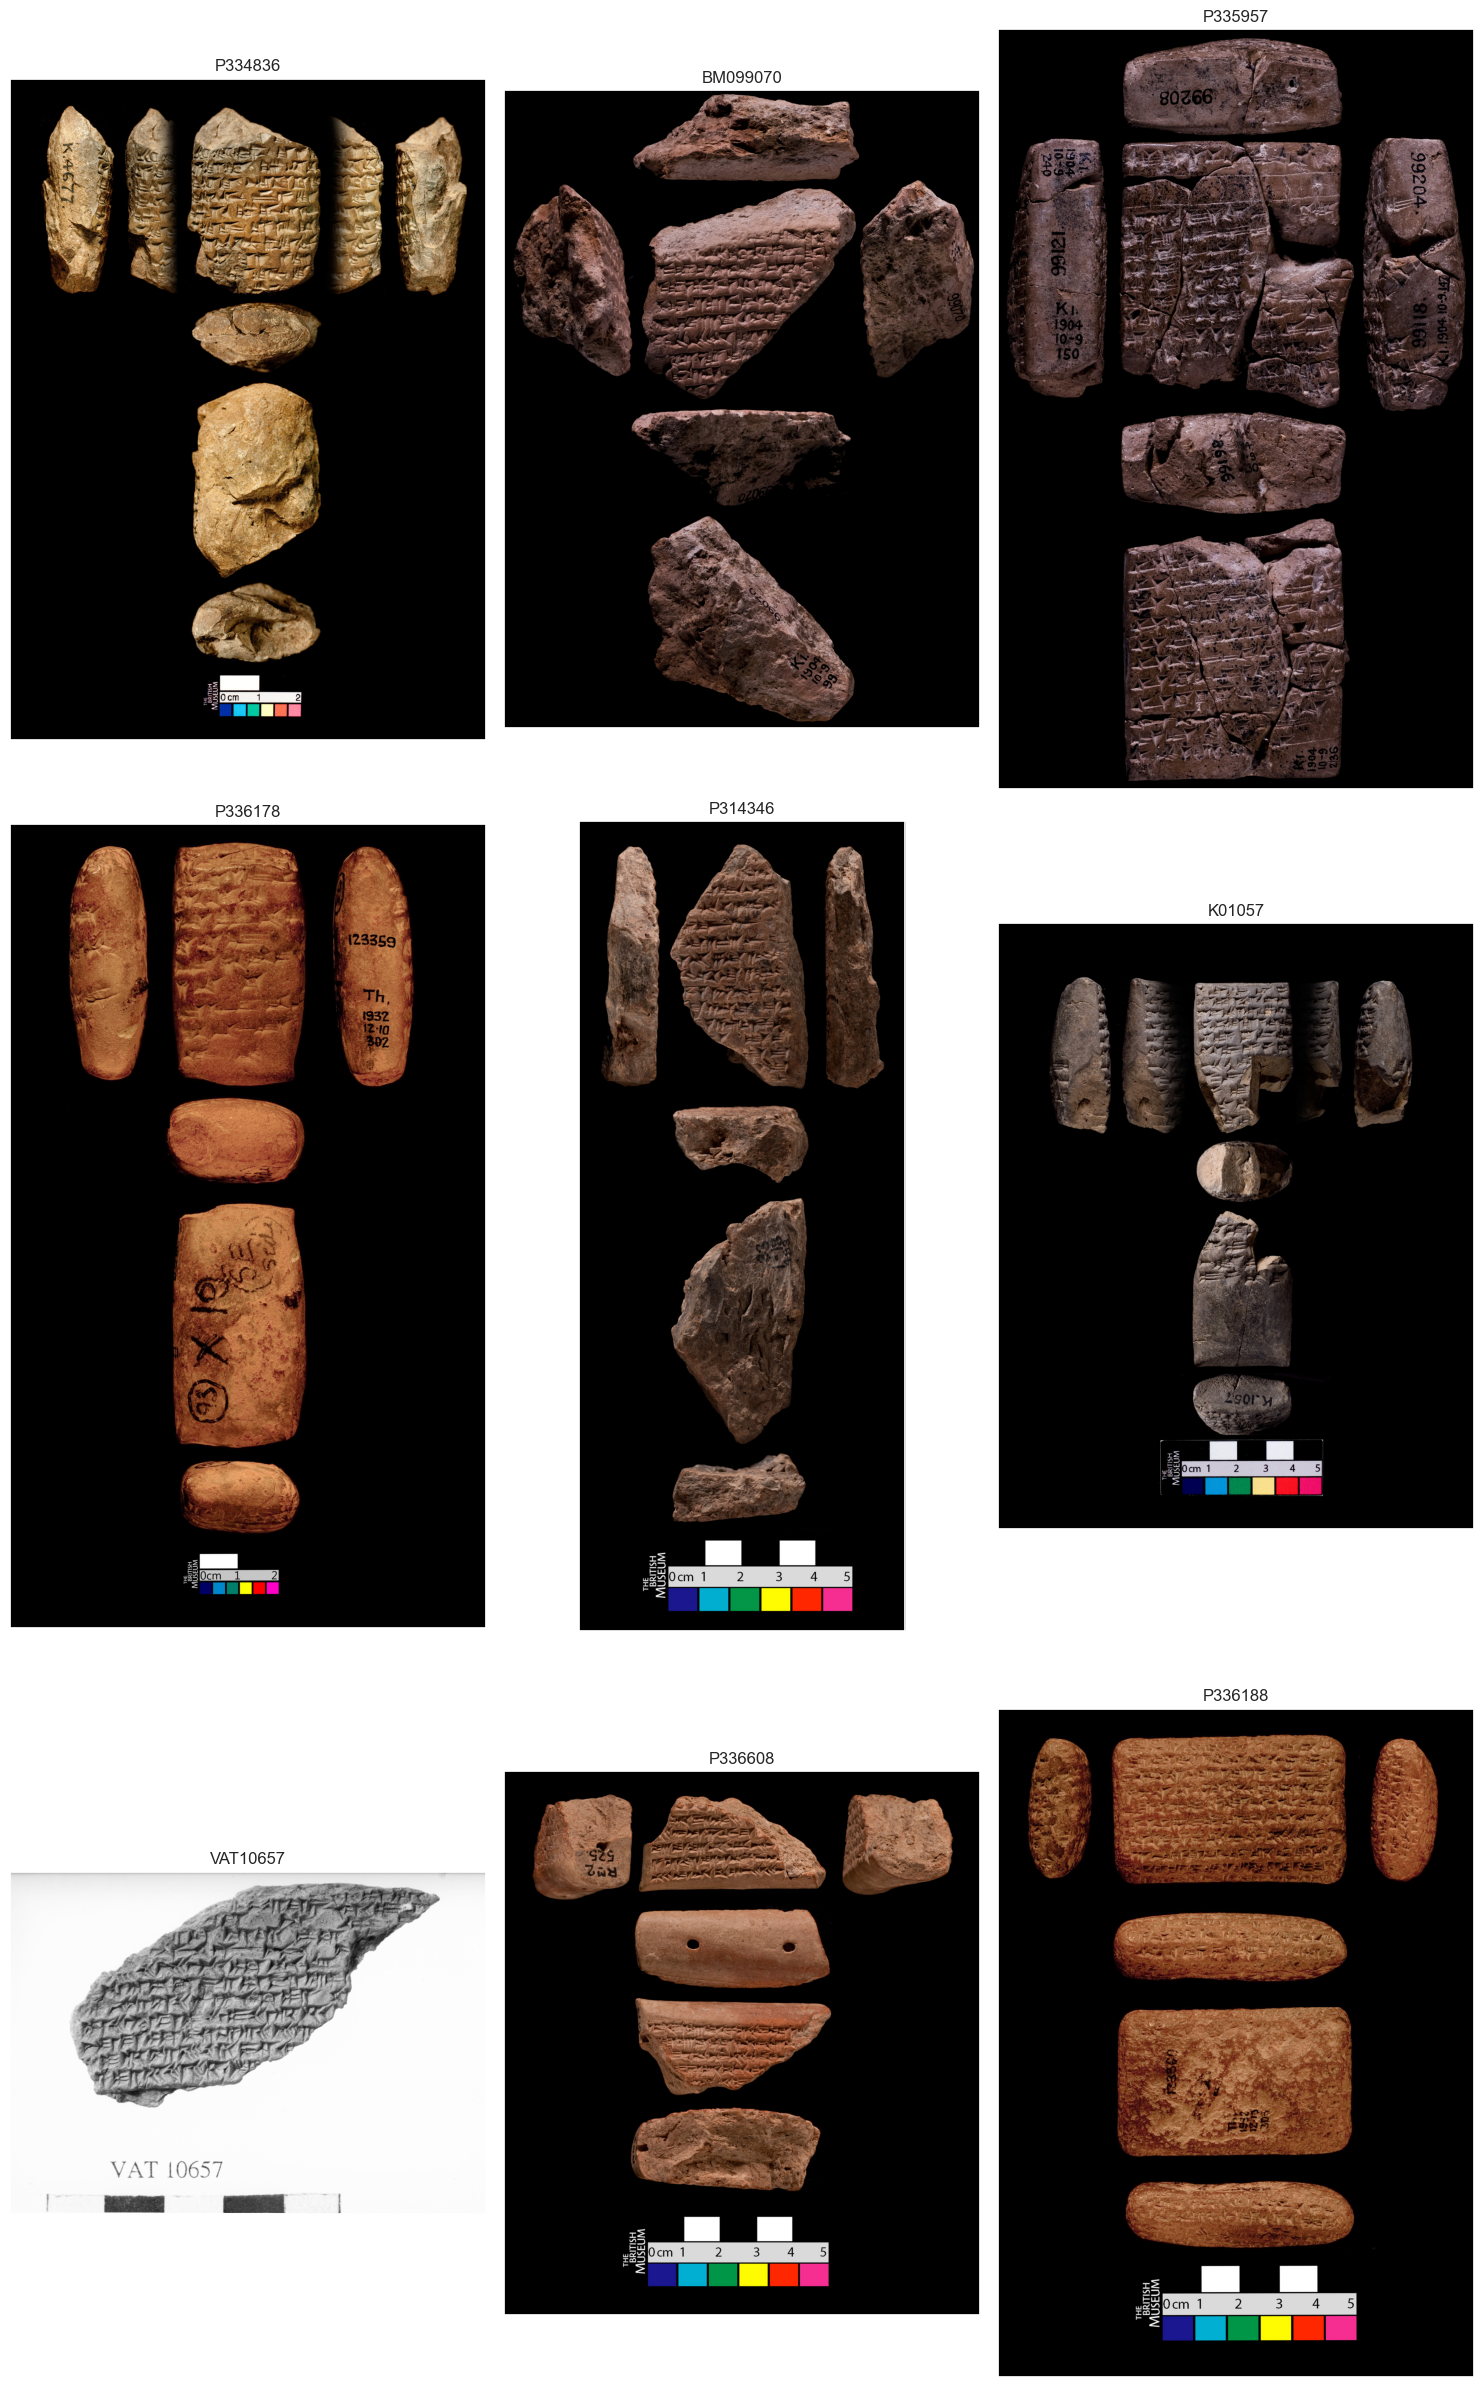

In [106]:
fig = plt.figure(figsize=(15, 25))

k = 0
for j in range(9):
    random_img = random.choice(img_list)
    img = mpimg.imread(random_img)

    k += 1
    ax = plt.subplot(3, 3, k)

    ax.imshow(img, cmap='gray', aspect='equal')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(os.path.basename(random_img)[:-4])     #-- Slice to del .jpg

plt.tight_layout()
plt.show()

<p style="text-align: justify; margin-left: 80px; margin-right: 80px;">
Les tablettes provenant de la collection CDLI comportent des vues de chacune des faces toutes en couleurs, là où les tablettes du Vorderasiatisches Museum Berlin (VAT) n'ont qu'une face visible et prise en noir et blanc. Les représentations ci-dessus attestent de la taille réduite des tablettes qui sont de l'ordre de quelques centimètres, entre 2cm et 5cm.
</p>

<p style="text-align: justify; margin-left: 80px; margin-right: 80px;">
Pour poursuivre l'analyse, il convient de vérifier que les données présentes dans les fichiers CSV fournissent les informations nécessaires pour identifier les glyphes sur les images.
</p>

<p style="text-align: justify; margin-left: 80px; margin-right: 80px;">
Pour ce faire, l'utilisation du fichier <em>'tablet_segments_train'</em> permettra de recadrer les images sur les faces identifiées, facilitant ainsi au fichier <em>'bbox_annotations_train_full'</em> le positionnement correct des 'box' labellisant les glyphes.
</p>

#### ---- Préparation des données

In [39]:
## -- Load the train annotations bbox and segments
bbox_df = pd.read_csv('../data/annotations/bbox_annotations_train_full.csv')
segments_df = pd.read_csv('../data/segments/tablet_segments_train.csv')

In [40]:
## -- Pick a random tablet in train set
tablets_from_train = segments_df['tablet_CDLI'].unique().tolist()
random_tablet = random.choice(tablets_from_train)

In [41]:
## -- Get the segment for the random tablet
segm_ref = segments_df[segments_df['tablet_CDLI'].isin([random_tablet])]

## -- Convert bbox into a np.array to use later
segm_ref['bbox'] = segm_ref['bbox'].apply(literal_eval).apply(np.array)

## -- Delete the NaN view_desc (not assigned segment)
segm_filter = segm_ref.dropna(subset=['view_desc'])


segm_filter

segm_idx tablet_CDLI view_desc collection                   bbox  scale  \
7         7     P404881       Obv      train    [358, 69, 840, 603]   3.58   
8         8     P404881       Rev      train  [362, 882, 833, 1411]   3.58   

   assigned  
7      True  
8      True

In [42]:
## -- Get the bbox for the random tablet
bbox_ref = bbox_df[bbox_df['tablet_CDLI'].isin([random_tablet])]

## -- Convert bbox and relative_bbox into a np.array to use later
bbox_ref['bbox'] = bbox_ref['bbox'].apply(literal_eval).apply(np.array)
bbox_ref['relative_bbox'] = bbox_ref['relative_bbox'].apply(literal_eval).apply(np.array)

## -- Delete the NaN view_desc (not assigned segment)
bbox_filter = bbox_ref.dropna(subset=['view_desc'])


bbox_filter.head()

segm_idx tablet_CDLI view_desc collection  mzl_label  train_label  \
1699         7     P404881       Obv      train        578           98   
1700         7     P404881       Obv      train        596           39   
1701         7     P404881       Obv      train        552           13   
1702         7     P404881       Obv      train        839           11   
1703         7     P404881       Obv      train        110            4   

                      bbox         relative_bbox  
1699  [399, 160, 446, 206]     [41, 91, 88, 137]  
1700  [440, 167, 504, 208]    [82, 98, 146, 139]  
1701  [500, 175, 576, 215]  [142, 106, 218, 146]  
1702  [585, 182, 628, 220]  [227, 113, 270, 151]  
1703  [618, 183, 682, 227]  [260, 114, 324, 158]

In [43]:
bbox_filter['view_desc'].value_counts()

view_desc
Obv    52
Rev    14
Name: count, dtype: int64

#### ---- Afficher les tablettes selon le.s segment.s prévu.s

In [44]:
def crop_img(img: Image.Image, bbox: np.ndarray) -> Image.Image:
    """Crop image reference to specific dimensions with bbox (x_min, y_min, x_max, y_max)"""
    return img.crop((bbox[0], bbox[1], bbox[2], bbox[3]))

In [45]:
## -- Get the path from the random tablet picked
path_tablet = next((tablet for tablet in img_list if random_tablet in tablet), None)
path_tablet

'../data/images/CDLI/P404881.jpg'

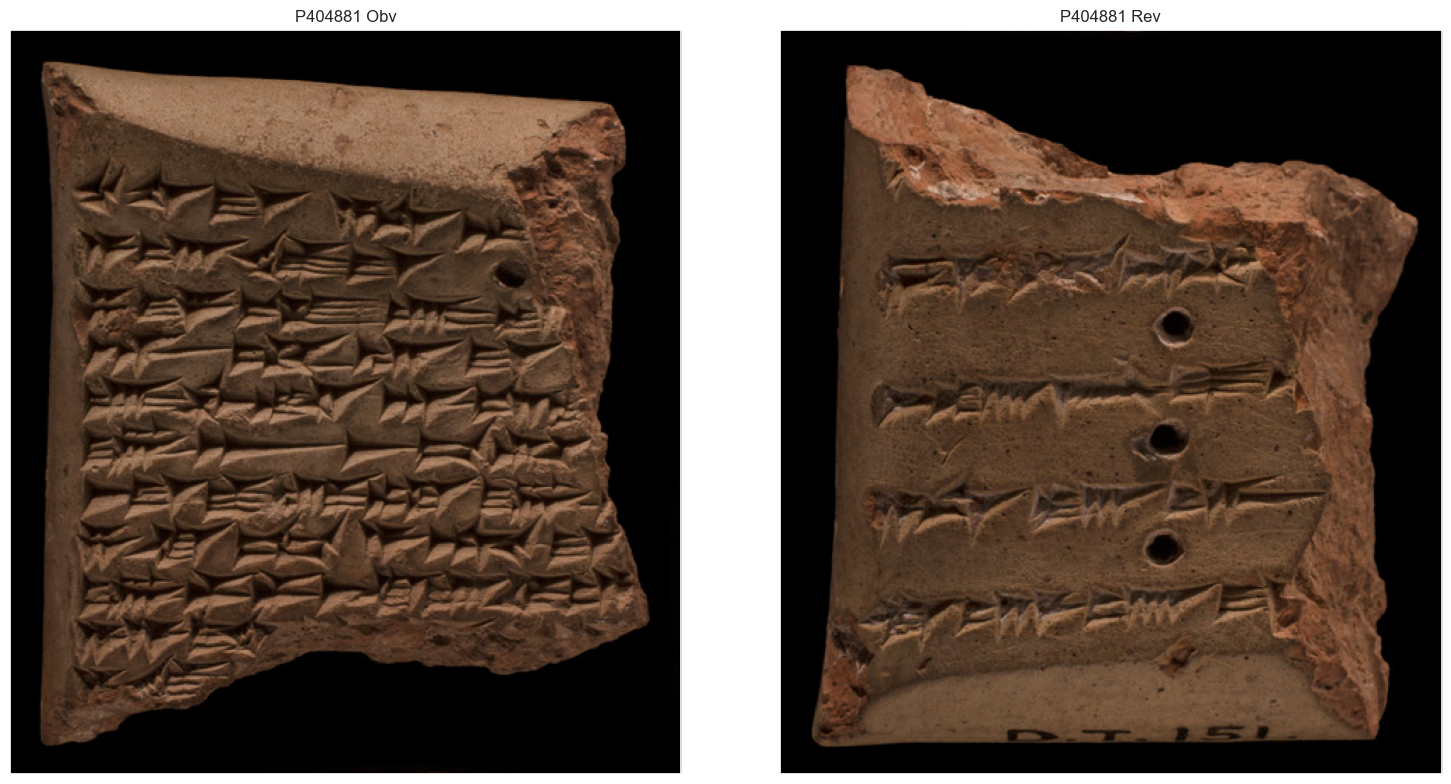

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

for idx, (s_idx, s_rec) in enumerate(segm_filter.iterrows()):
    pil_im = Image.open(path_tablet)    #- Need PIL to use crop method
    tablet_seg = crop_img(pil_im, s_rec.bbox)

    ax[idx].imshow(np.asarray(tablet_seg))
    ax[idx].set_title(f"{s_rec['tablet_CDLI']} {s_rec['view_desc']}")
    ax[idx].set_xticks([])
    ax[idx].set_yticks([])

plt.tight_layout()
plt.show()

#### ---- Afficher les bbox des glyphes

In [47]:
def plot_boxes(boxes: np.ndarray, labels: np.ndarray, ax: plt.Axes) -> None:
    # if ax is None:
    #     fig, ax = plt.subplots(figsize=(15, 12))

    for idx, bbox in enumerate(boxes):
        ## - Plot BBox
        ax.add_patch(
            plt.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1],
                          fill=False, 
                          edgecolor='#7878bf', 
                          alpha=0.8, 
                          linewidth=1.4))

        ## - Plot Label 
        ax.text(bbox[0], bbox[1] - 2, f"{labels[idx]}",
                bbox=dict(facecolor='blue', alpha=0.4), fontsize=8, color='white')

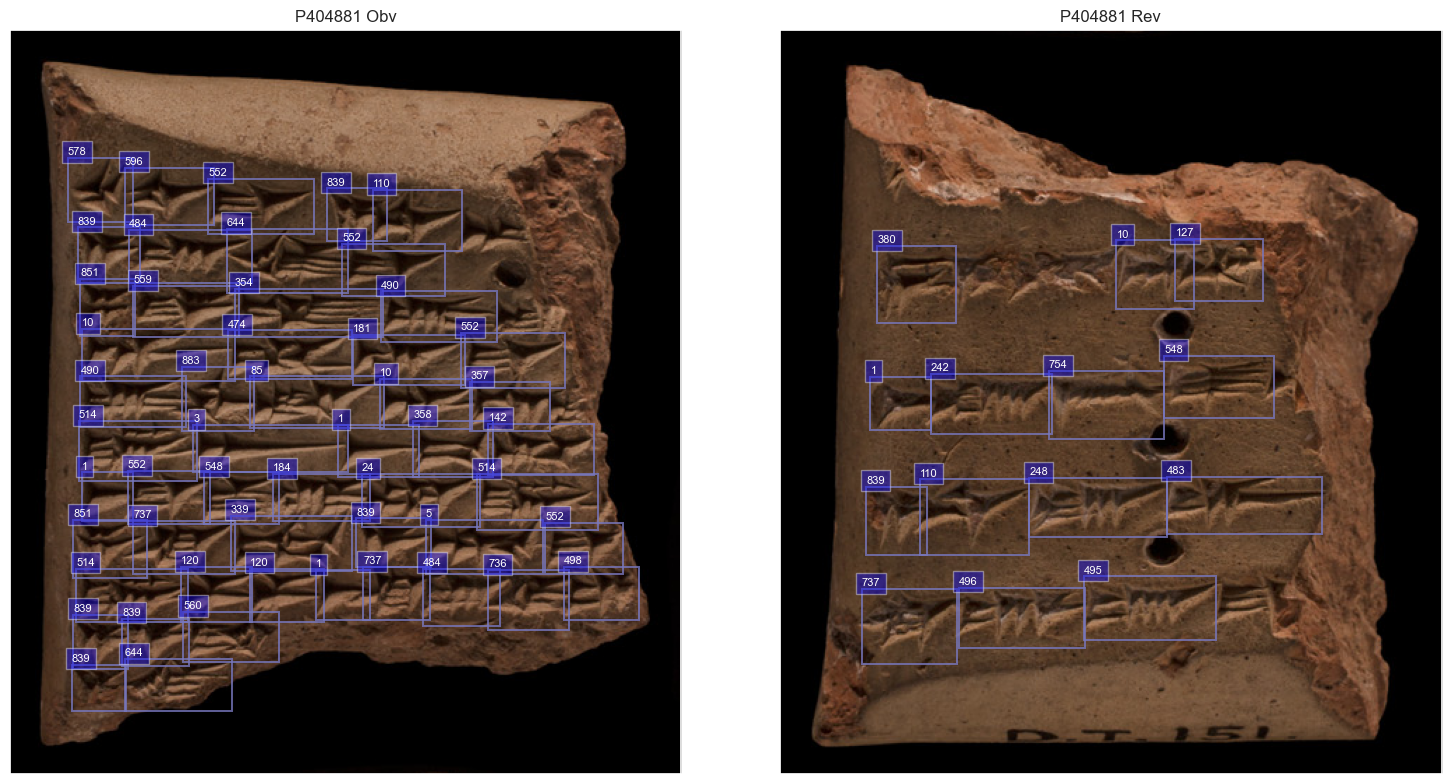

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

for idx, (s_idx, s_rec) in enumerate(segm_filter.iterrows()):
    ## - Display each segment
    pil_im = Image.open(path_tablet)    #- Need PIL to use crop method
    tablet_seg = crop_img(pil_im, s_rec.bbox)

    ax[idx].imshow(np.asarray(tablet_seg))
    ax[idx].set_title(f"{s_rec['tablet_CDLI']} {s_rec['view_desc']}")
    ax[idx].set_xticks([])
    ax[idx].set_yticks([])

    ## - Select bbox for the segment
    selected_segm = (bbox_filter['segm_idx'] == s_rec['segm_idx'])

    sign_bboxes = bbox_filter[selected_segm]['relative_bbox'].values
    ## - Check if the list is not empty
    if len(sign_bboxes) > 0 and any(array is not None for array in sign_bboxes):
        sign_bboxes = np.stack(sign_bboxes)
        sign_lbls = bbox_filter[selected_segm]['mzl_label'].values

        plot_boxes(sign_bboxes, sign_lbls, ax=ax[idx])

plt.tight_layout()
plt.show()

<p style="text-align: justify; margin-left: 80px; margin-right: 80px;">
Cette vérification permet de garantir la concordance entre les images et les fichiers CSV. Le dernier exemple montre que les informations liées à la labellisation des glyphes sont correctement associées à l'emplacement de ces dernier."
</p>

#### ---- Correspondance entre la labellisation et le glyphe

<p style="text-align: justify; margin-left: 80px; margin-right: 80px;">
La présente labellisation étant faite par des Assyriologues (PhD), il est peu probable qu'un mauvais étiquettage ait été fait. Néanmoins, une vérification pour s'en assurer n'est pas superflue, afin de s'assurer que la labellisation est correct et ne donnera pas de mauvais résultat lors de l'apprentissage du modèle d'IA.
</p>

<p style="text-align: justify; margin-left: 80px; margin-right: 80px;">
Pour ce faire, un échantillon des labellisations de l'image sera mis en regard du fichier JSON, créé lors du webscraping du site eBL, pour comparer les glyphes selon leur MZL code.
</p>

In [50]:
## - Load the JSON MZL Reference
with open('../data/neo_assyrian_info.json', 'r', encoding='utf-8') as mzl_json:
    mzl_data = json.load(mzl_json)

In [51]:
## - Pick random MZL in previous image
label_img = random.sample(np.unique(sign_lbls).tolist(), k=3)

In [52]:
## - Configure the df to get only random_mzl bbox
bbox_random_label = bbox_filter[bbox_filter['mzl_label'].isin(label_img)]

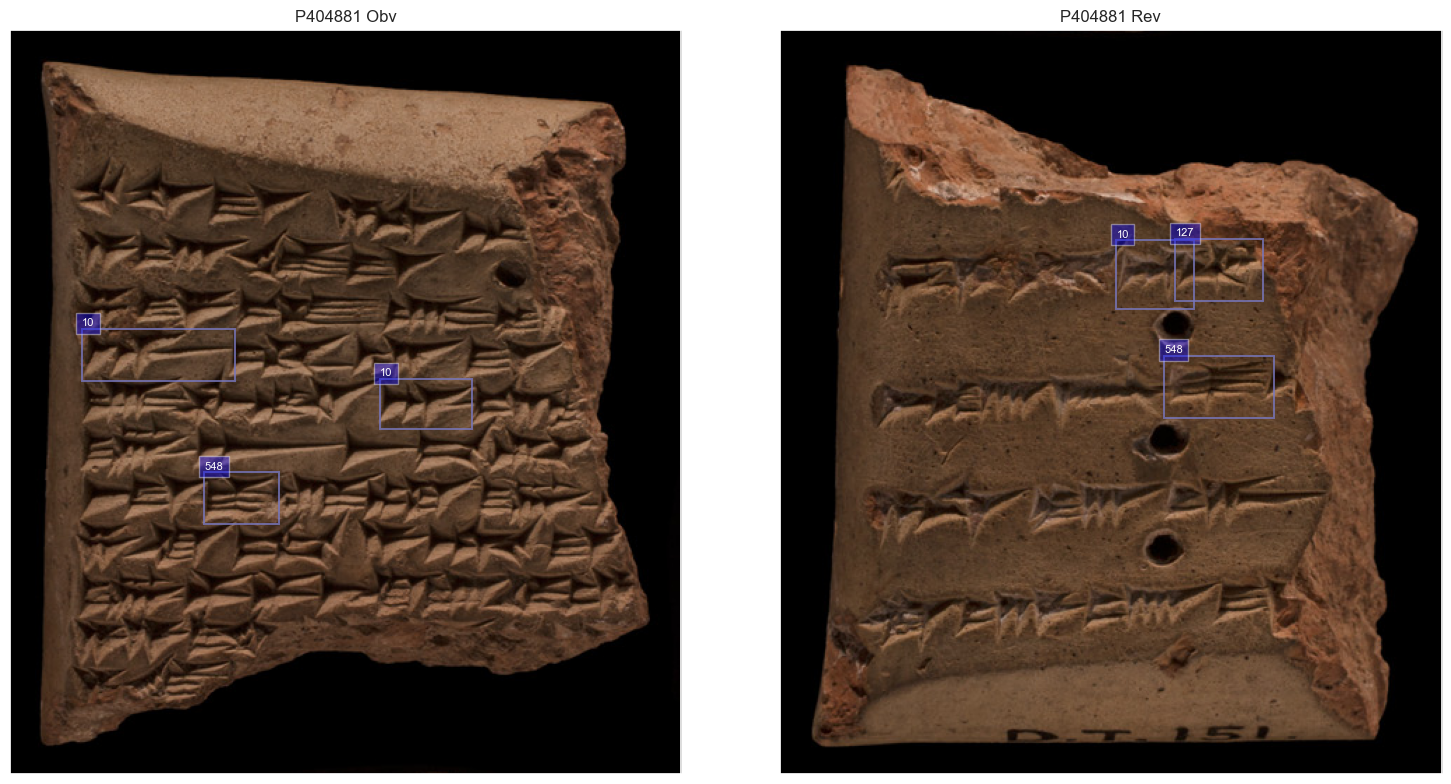

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

for idx, (s_idx, s_rec) in enumerate(segm_filter.iterrows()):
    ## - Display each segment
    pil_im = Image.open(path_tablet)    #- Need PIL to use crop method
    tablet_seg = crop_img(pil_im, s_rec.bbox)

    ax[idx].imshow(np.asarray(tablet_seg))
    ax[idx].set_title(f"{s_rec['tablet_CDLI']} {s_rec['view_desc']}")
    ax[idx].set_xticks([])
    ax[idx].set_yticks([])

    ## - Select bbox for the segment
    selected_segm = (bbox_random_label['segm_idx'] == s_rec['segm_idx'])

    sign_bboxes = bbox_random_label[selected_segm]['relative_bbox'].values
    ## - Check if the list is not empty
    if len(sign_bboxes) > 0 and any(array is not None for array in sign_bboxes):
        choose_sign_bboxes = np.stack(sign_bboxes)
        choose_sign_lbls = bbox_random_label[selected_segm]['mzl_label'].values

        plot_boxes(choose_sign_bboxes, choose_sign_lbls, ax=ax[idx])

plt.tight_layout()
plt.show()

In [54]:
for label in label_img:
    print(f"Image Label : {label} --> MZL Reference : {mzl_data[label-1]['glyph']}")

Image Label : 548 --> MZL Reference : 𒀾
Image Label : 127 --> MZL Reference : 𒀝
Image Label : 10 --> MZL Reference : 𒀭


<p style="text-align: justify; margin-left: 80px; margin-right: 80px;">
Le contrôle indique bien l'exactitude des glyphes labellisés avec le référentiel MZL. Certains unicode peuvent sembler différent de ce qui est présent sur la tablette, mais une vérification rapide sur le site de référence <a href='https://www.ebl.uni-muenchen.de/signs'>eBL</a> prouve la concordance.
</p>

----
## Résumé

<p style="text-align: justify; margin-left: 80px; margin-right: 80px;">
L'Analyse Exploratoire des Données (EDA) a validé la cohérence entre les images téléchargées (VAT et CDLI) et les fichiers CSV de la dataset. Les données se révèlent fiables, fournissant des bounding boxes précises et une labellisation adéquate pour les glyphes présents sur les échantillons effectués ci-dessus. La dernière étape de vérification, comparant la labellisation réalisé par les chercheurs au référentiel MZL, confirme la qualité de la dataset pour poursuivre le projet.
</p>

----
#
<h2 style="text-align: center;">FIN - NOTEBOOK IMAGES</h2>